## Including Headers

In [1]:
import modelo as m
import pandas as pd
import Bio.KEGG.REST as rkg
import Bio.KEGG.Enzyme as ex
import networkx as nx
import cufflinks as cf
import pylab as pl
import numpy as np
import plotly.tools as tls
import powerlaw
from plotly.graph_objs import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
from plotly.offline import *
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import random
from sklearn.preprocessing import label_binarize
import time

random.seed(42)

init_notebook_mode(connected=True)

###  First Attempt: Classification with all nodes and using undirected network

In [2]:
def roc(X_train, y_train, X_test, y_test, mean_fpr, aucs, tprs, cls, l):
    '''
        This method in based on:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
    '''
    i = 0
    for c in cls:
        probas_ = c.fit(X_train, y_train).predict_proba(X_test)
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(label_binarize(y_test, classes=[0, 1]), probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC %s (AUC = %0.2f)' % (l[i], roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    return(plt)

#### Defining all classifiers and parameters

In [3]:

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(kernel="sigmoid", C=0.025, probability=True),
    SVC(kernel="rbf", C=0.025, probability=True),
    SVC(gamma=2, C=1,probability=True),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB()]
cls = ['KNN',
      "SVM linear",
       "SVM sigmoid",
      "SVM RBF",
      "SVM gamma",
      "Gauss",
      "AD",
      "RF",
      "MLP",
      "AdaBoost",
      "Net Bayes"
      ]

#### Reading data

In [4]:
sce = pd.read_csv("data/scerevisiae_all.csv")
ecoli = pd.read_csv("data/ecoli_all.csv")
pae = pd.read_csv("data/paeruginosa_all.csv")
mge = pd.read_csv("data/mgenitalium_all.csv")

#### Splitting train and test datasets

In [5]:
sce_x, sce_y = sce.iloc[:,2:-1],sce['class']
eco_x, eco_y = ecoli.iloc[:,2:-1],ecoli['class']
pae_x, pae_y = pae.iloc[:,2:-1],pae['class']
mge_x, mge_y = mge.iloc[:,2:-1],mge['class']
# Class redefinition 0:essential 1:unknown/non-essential
sce_y.replace(1,0, inplace=True)
sce_y.replace(2,1, inplace=True)
sce_y.replace(3,1, inplace=True)
eco_y.replace(1,0, inplace=True)
eco_y.replace(2,1, inplace=True)
eco_y.replace(3,1, inplace=True)
pae_y.replace(1,0, inplace=True)
pae_y.replace(2,1, inplace=True)
pae_y.replace(3,1, inplace=True)
mge_y.replace(1,0, inplace=True)
mge_y.replace(2,1, inplace=True)
mge_y.replace(3,1, inplace=True)

#### Building dataset: Leave one out strategy

In [6]:
train1_x = pd.concat([sce_x,mge_x,pae_x])
train1_y = pd.concat([sce_y,mge_y,pae_y])
test1_x = eco_x 
test1_y = eco_y
#------------------------------------------------------------------------------------
train2_x = pd.concat([eco_x,mge_x,pae_x])
train2_y = pd.concat([eco_y,mge_y,pae_y])
test2_x = sce_x 
test2_y = sce_y
#------------------------------------------------------------------------------------
train3_x = pd.concat([eco_x,sce_x,pae_x])
train3_y = pd.concat([eco_y,sce_y,pae_y])
test3_x = mge_x 
test3_y = mge_y
#------------------------------------------------------------------------------------
train4_x = pd.concat([eco_x,sce_x,mge_x])
train4_y = pd.concat([eco_y,sce_y,mge_y])
test4_x = pae_x 
test4_y = pae_y

#### Testing Machine Learning Classifiers 

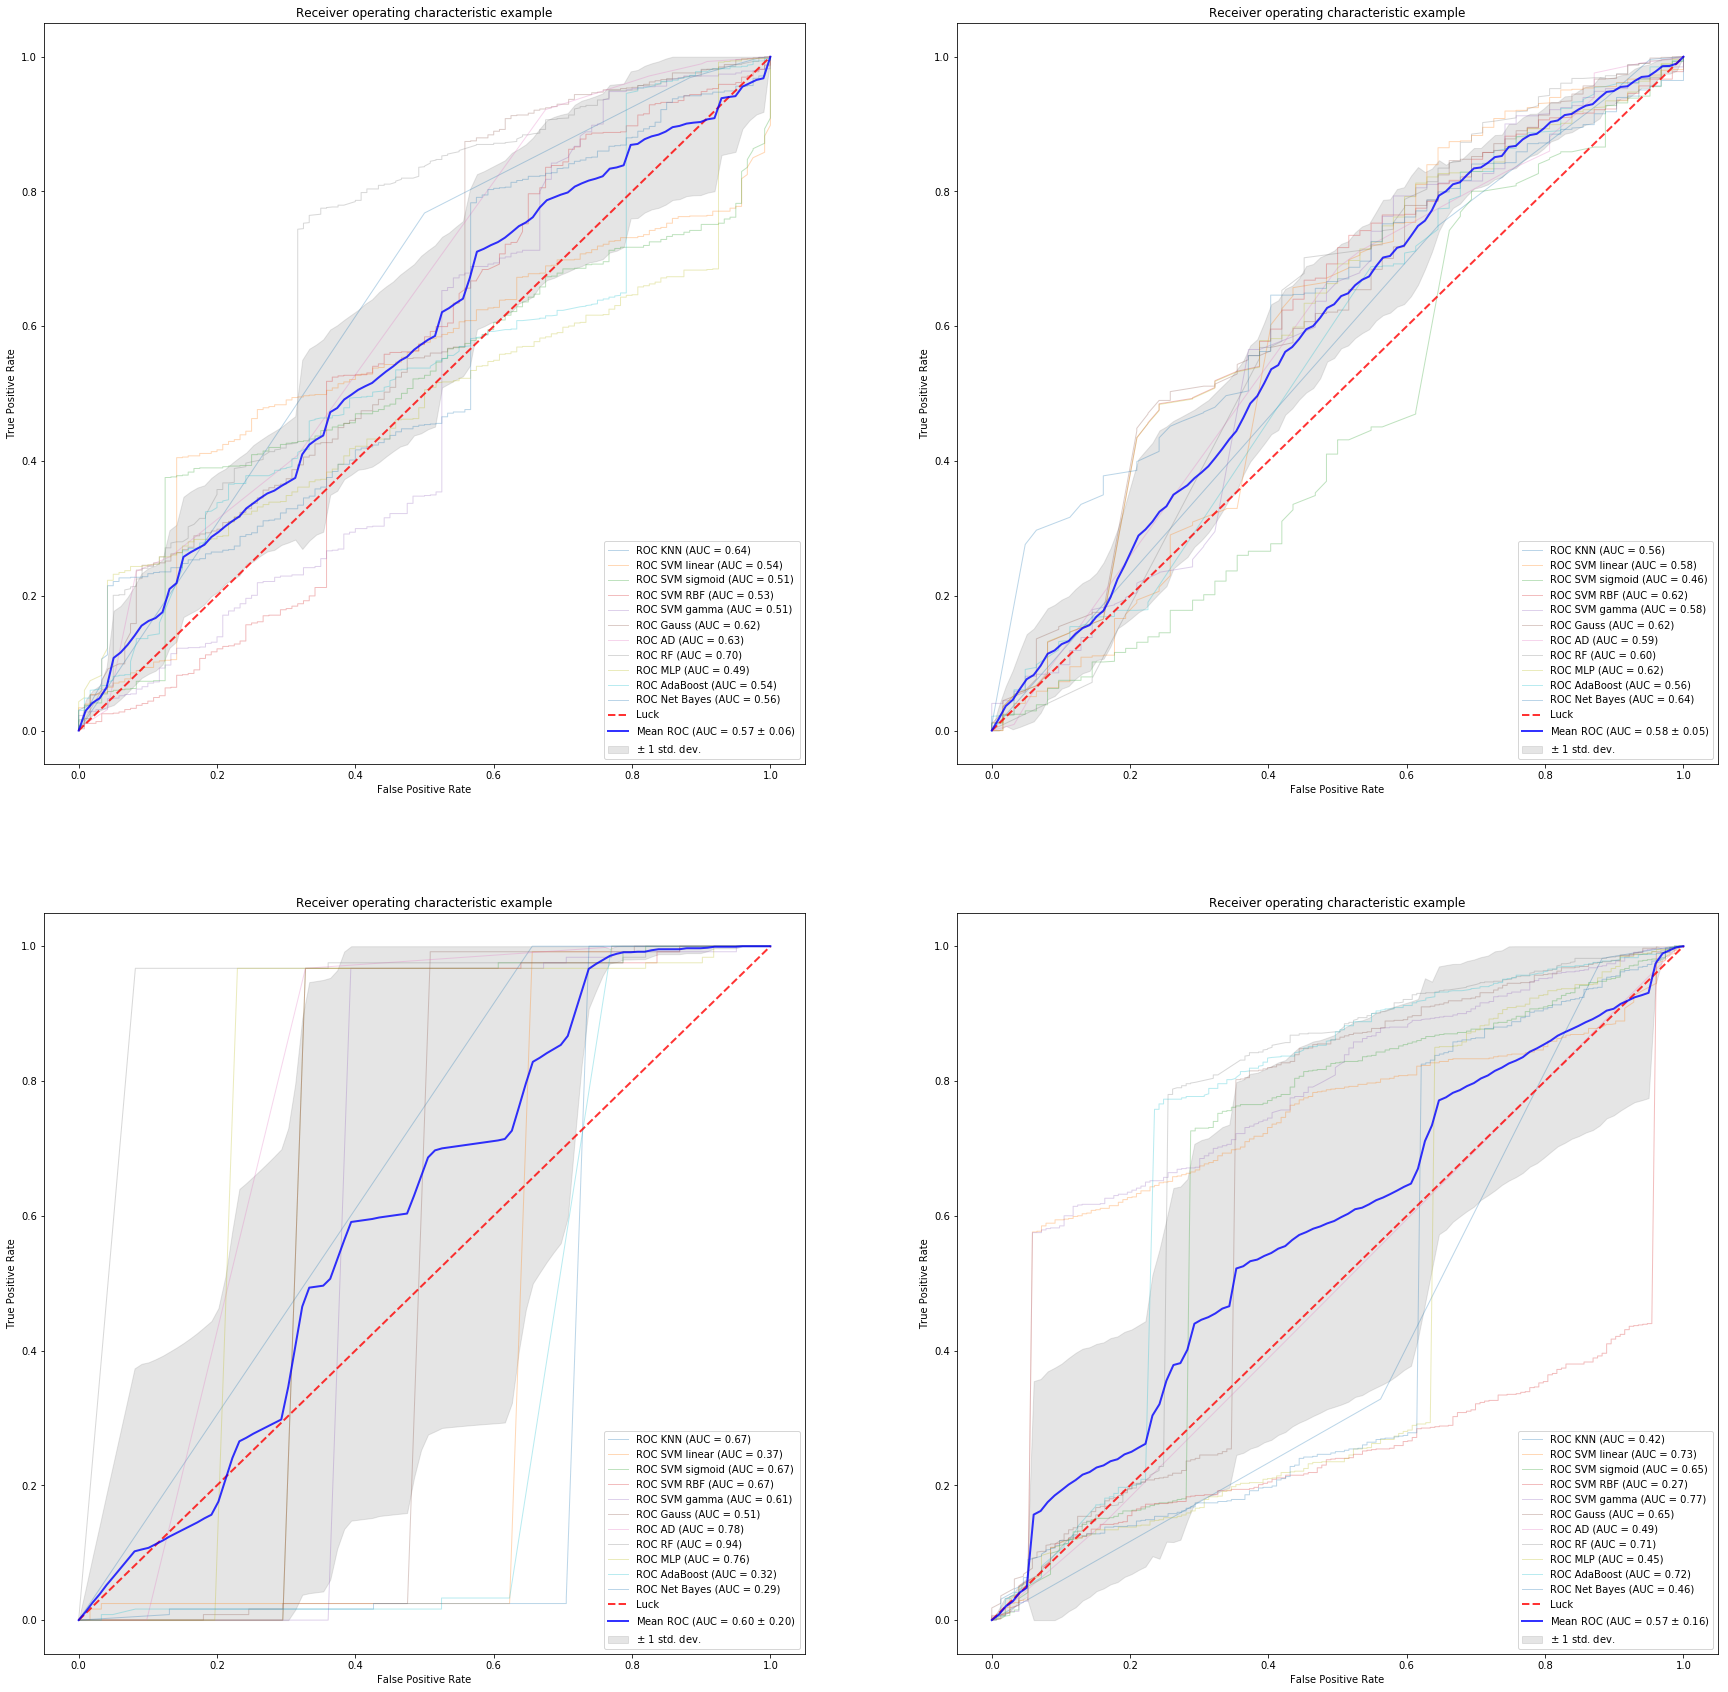

In [7]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(train1_x,train1_y,test1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 =  time.time() -s1 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(train2_x,train2_y,test2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 =  time.time() -s2 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(train3_x,train3_y,test3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4= time.time()
imgshow = roc(train4_x,train4_y,test4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 =  time.time() -s4
fig.savefig("all_nfs.png")


In [8]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

Time for machine learning test

Dataset1: --- 320.14588236808777 seconds ---
Dataset2: --- 336.9526484012604 seconds ---
Dataset3: --- 680.0844132900238 seconds ---
Dataset4: --- 165.277916431427 seconds ---


#### Testing Machine Learning Classifiers with Feature Selection

In [9]:
X_new1 = SelectKBest(chi2, k=7).fit(train1_x,train1_y)
ntrain1_x = train1_x.iloc[:,X_new1.get_support()]
ntest1_x = test1_x.iloc[:,X_new1.get_support()]
#------------------------------------------------------------------------------------
X_new2 = SelectKBest(chi2, k=7).fit(train2_x,train2_y)
ntrain2_x = train2_x.iloc[:,X_new2.get_support()]
ntest2_x = test2_x.iloc[:,X_new2.get_support()]
#------------------------------------------------------------------------------------
X_new3 = SelectKBest(chi2, k=7).fit(train3_x,train3_y)
ntrain3_x = train3_x.iloc[:,X_new3.get_support()]
ntest3_x = test3_x.iloc[:,X_new3.get_support()]
#------------------------------------------------------------------------------------
X_new4 = SelectKBest(chi2, k=7).fit(train4_x,train4_y)
ntrain4_x = train4_x.iloc[:,X_new4.get_support()]
ntest4_x = test4_x.iloc[:,X_new4.get_support()]


In [ ]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(ntrain1_x,train1_y,ntest1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 = time.time() - s1
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(ntrain2_x,train2_y,ntest2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 = time.time() - s2
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(ntrain3_x,train3_y,ntest3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4= time.time()
imgshow = roc(ntrain4_x,train4_y,ntest4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 = time.time() - s4
fig.savefig("all_fs.png")


In [ ]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

###  Second Attempt: Classification without isolate nodes and using undirected network

#### Reading data

In [ ]:
sce = pd.read_csv("data/scerevisiae.csv")
ecoli = pd.read_csv("data/ecoli.csv")
pae = pd.read_csv("data/paeruginosa.csv")
mge = pd.read_csv("data/mgenitalium.csv")

#### Splitting train and test datasets

In [ ]:
sce_x, sce_y = sce.iloc[:,2:-1],sce['class']
eco_x, eco_y = ecoli.iloc[:,2:-1],ecoli['class']
pae_x, pae_y = pae.iloc[:,2:-1],pae['class']
mge_x, mge_y = mge.iloc[:,2:-1],mge['class']
# Class redefinition 0:essential 1:unknown/non-essential
sce_y.replace(1,0, inplace=True)
sce_y.replace(2,1, inplace=True)
sce_y.replace(3,1, inplace=True)
eco_y.replace(1,0, inplace=True)
eco_y.replace(2,1, inplace=True)
eco_y.replace(3,1, inplace=True)
pae_y.replace(1,0, inplace=True)
pae_y.replace(2,1, inplace=True)
pae_y.replace(3,1, inplace=True)
mge_y.replace(1,0, inplace=True)
mge_y.replace(2,1, inplace=True)
mge_y.replace(3,1, inplace=True)

#### Building dataset: Leave one out strategy

In [ ]:
train1_x = pd.concat([sce_x,mge_x,pae_x])
train1_y = pd.concat([sce_y,mge_y,pae_y])
test1_x = eco_x 
test1_y = eco_y
#------------------------------------------------------------------------------------
train2_x = pd.concat([eco_x,mge_x,pae_x])
train2_y = pd.concat([eco_y,mge_y,pae_y])
test2_x = sce_x 
test2_y = sce_y
#------------------------------------------------------------------------------------
train3_x = pd.concat([eco_x,sce_x,pae_x])
train3_y = pd.concat([eco_y,sce_y,pae_y])
test3_x = mge_x 
test3_y = mge_y
#------------------------------------------------------------------------------------
train4_x = pd.concat([eco_x,sce_x,mge_x])
train4_y = pd.concat([eco_y,sce_y,mge_y])
test4_x = pae_x 
test4_y = pae_y

#### Testing Machine Learning Classifiers 

In [ ]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(train1_x,train1_y,test1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 =  time.time() -s1 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(train2_x,train2_y,test2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 =  time.time() -s2 
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(train3_x,train3_y,test3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4= time.time()
imgshow = roc(train4_x,train4_y,test4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 =  time.time() -s4
fig.savefig("wi_nfs.png")

In [ ]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)

#### Testing Machine Learning Classifiers with Feature Selection

In [ ]:
X_new1 = SelectKBest(chi2, k=7).fit(train1_x,train1_y)
ntrain1_x = train1_x.iloc[:,X_new1.get_support()]
ntest1_x = test1_x.iloc[:,X_new1.get_support()]
#------------------------------------------------------------------------------------
X_new2 = SelectKBest(chi2, k=7).fit(train2_x,train2_y)
ntrain2_x = train2_x.iloc[:,X_new2.get_support()]
ntest2_x = test2_x.iloc[:,X_new2.get_support()]
#------------------------------------------------------------------------------------
X_new3 = SelectKBest(chi2, k=7).fit(train3_x,train3_y)
ntrain3_x = train3_x.iloc[:,X_new3.get_support()]
ntest3_x = test3_x.iloc[:,X_new3.get_support()]
#------------------------------------------------------------------------------------
X_new4 = SelectKBest(chi2, k=7).fit(train4_x,train4_y)
ntrain4_x = train4_x.iloc[:,X_new4.get_support()]
ntest4_x = test4_x.iloc[:,X_new4.get_support()]


In [ ]:
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
fig = plt.figure(figsize=(30,30))
row = 2
col = 2
a = fig.add_subplot(row, col, 1)
s1 = time.time()
imgshow = roc(ntrain1_x,train1_y,ntest1_x,test1_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s1 = time.time() - s1
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 2)
s2 = time.time()
imgshow = roc(ntrain2_x,train2_y,ntest2_x,test2_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s2 = time.time() - s2
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 3)
s3 = time.time()
imgshow = roc(ntrain3_x,train3_y,ntest3_x,test3_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s3 = time.time() - s3
#------------------------------------------------------------------------------------
tprs_dall = []
aucs_dall = []
mean_fpr_dall = np.linspace(0, 1, 100)
a = fig.add_subplot(row, col, 4)
s4= time.time()
imgshow = roc(ntrain4_x,train4_y,ntest4_x,test4_y, mean_fpr_dall, aucs_dall,tprs_dall,classifiers,cls)
s4 = time.time() - s4
fig.savefig("wi_fs.png")



In [ ]:
print("Time for machine learning test\n")
print("Dataset1: --- %s seconds ---" % s1)
print("Dataset2: --- %s seconds ---" % s2)
print("Dataset3: --- %s seconds ---" % s3)
print("Dataset4: --- %s seconds ---" % s4)